Описание задания  
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
df = pd.read_csv('hw_aa.csv', sep=';')

In [10]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Описание колонок:  
- experimentVariant – вариант эксперимента  
- version – версия приложения  
- purchase – факт покупки  

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


Пороведем AA test, убедимся что система сплитования слована

In [15]:
a1 = df[df.experimentVariant == 1]['purchase']
a2 = df[df.experimentVariant == 0]['purchase']

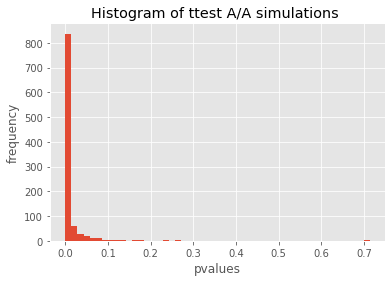

0.932

In [17]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = a1.sample(n_s, replace = False).values
    s2 = a2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Действительно FRP 0.932 значительно больше $\alpha$ 0.05

посмотрим на конвесию в общем и в частности в разбивке по версиям

In [25]:
print(df[df.experimentVariant == 1]['purchase'].mean())
print(df[df.experimentVariant == 0]['purchase'].mean())

0.05324175480317917
0.02394535830876993


In [26]:
df.groupby(['version', 'experimentVariant'], as_index=False)['purchase'].mean()

,version,experimentVariant,purchase
0,v2.8.0,0,0.000993
1,v2.8.0,1,0.045606
2,v2.9.0,0,0.074658
3,v2.9.0,1,0.071304
4,v3.7.4.0,0,0.059943
5,v3.7.4.0,1,0.063018
6,v3.8.0.0,0,0.057604
7,v3.8.0.0,1,0.062848


можно увидеть, что конверсия сильно отличается в версии мп 2.8.0. исключим  ее из теста.


In [28]:
a1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase']
a2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase']

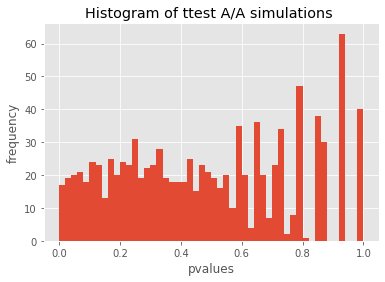

0.05

In [29]:
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = a1.sample(n_s, replace = False).values
    s2 = a2.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Теперь между группами нет стат различий. Данные можно использовать для проведения дальнейших расчетов, только без учета версии 2.8.0. Судя по существенной разнице в конверсии у части пользователей возникли проблемы в этом частном случае.
